## Neural Style Transfer를 이용한 서명 스타일 학습
- Neural Style Transfer는 content 이미지와 style reference 이미지를 이용하여, 콘텐츠 이미지의 콘텐츠는 유지하되 스타일 찹조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술
- 모델의 입력층부터 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응하고, 최종 몇 개의 층은 바퀴나 눈과 같은 고차원적 특성들을 나타냄
- 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용
- 원하는 스타일 전이가 일어나지 않음 (질감 등의 스타일만 변화함)
- 본 코드에서는 VGG19 모델의 중간층 사용 -> 폰트, 글자라는 특성에 맞게 초반층 또는 최종층으로 변경해서 시도


In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os

import tensorflow as tf

In [ ]:
# tensor를 이미지로 변환
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# 스타일 참조 이미지(서명 이미지)와 콘텐츠 이미지(손글씨 이미지) 세팅
content_path = os.path.join("handwriting.PNG")
style_path = os.path.join("style.png")

In [ ]:
# 이미지 불러옴 (최대 이미지 크기를 512로 제한)
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
# 이미지 출력 함수
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

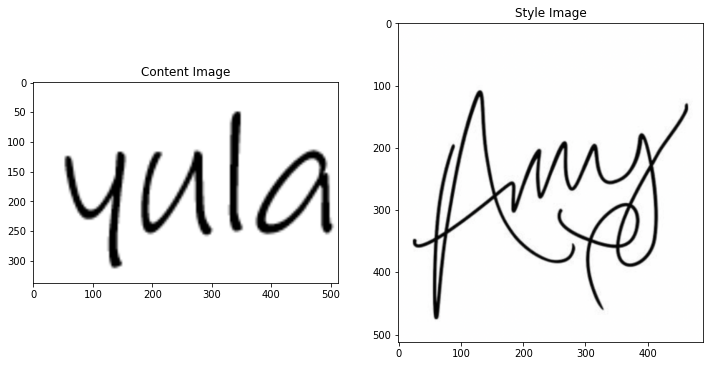

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

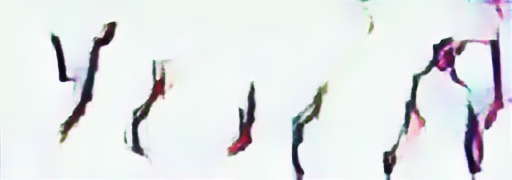

In [ ]:
# 텐서플로우 허브 모듈(기존의 style transfer algorithm)이 생성하는 결과물 테스트
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
# VGG 모델 불러오고 작동 여부 확인
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('nail', 0.12664045),
 ('hook', 0.12028634),
 ('hair_slide', 0.033076428),
 ('cleaver', 0.031737898),
 ('tick', 0.025785198)]

In [ ]:
# 분류층을 제외한 VGG19 모델 부르고 각 층 이름 출력
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# 이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간충 선택
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
# 중간층의 결과물을 배열로 출력하는 VGG 모델 반환
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 512, 489, 64)
  최솟값:  0.0
  최댓값:  875.97107
  평균:  36.251015

block2_conv1
  크기:  (1, 256, 244, 128)
  최솟값:  0.0
  최댓값:  3585.9558
  평균:  212.33592

block3_conv1
  크기:  (1, 128, 122, 256)
  최솟값:  0.0
  최댓값:  11010.76
  평균:  178.18153

block4_conv1
  크기:  (1, 64, 61, 512)
  최솟값:  0.0
  최댓값:  16486.5
  평균:  621.13043

block5_conv1
  크기:  (1, 32, 30, 512)
  최솟값:  0.0
  최댓값:  3066.2979
  평균:  38.258564



In [ ]:
# gram matrix는 중간층들의 feature map의 평균과 그들 사이의 상관관계를 담고 있고, feature vector끼리의 외적의 평균값으로 계산함 (tf.linalg.einsum 함수 이용)
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
# 이미지가 입력으로 주어졌을 때 스타일와 콘텐츠 텐서(gram matrix)를 반환
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # inputs은 0과 1 사이의 실수
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0
    최댓값:  189352.1
    평균:  615.6762

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  313719.6
    평균:  18809.965

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  457237.56
    평균:  18073.418

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  5597918.0
    평균:  220411.61

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  114624.13
    평균:  1238.5927

콘텐츠:
   block5_conv2
    크기:  (1, 21, 32, 512)
    최솟값:  0.0
    최댓값:  1273.7828
    평균:  10.745621


In [ ]:
# 스타일과 콘텐츠의 타깃값 지정
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
type(content_targets)
content_targets

{'block5_conv2': <tf.Tensor: shape=(1, 21, 32, 512), dtype=float32, numpy=
 array([[[[ 0.       ,  0.       , 36.88511  , ...,  0.       ,
           41.87519  ,  0.       ],
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           77.49919  ,  0.       ],
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           72.77915  ,  0.       ],
          ...,
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           69.16454  ,  0.       ],
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           67.3564   ,  0.       ],
          [ 1.8203877,  0.       ,  0.       , ...,  0.       ,
           57.122726 ,  0.       ]],
 
         [[ 0.       ,  0.       , 23.400206 , ...,  0.       ,
            0.       ,  0.       ],
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
            0.       ,  0.       ],
          [ 0.       ,  0.       ,  0.       , ...,  0.       ,
            0.       ,  0.       ],
       

In [ ]:
# 최적화시킬 이미지를 담을 변수 정의 후 콘텐츠 이미지로 초기화
image = tf.Variable(content_image)

In [ ]:
# 픽셀값이 실수이므로 0과 1 사이로 클리핑
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# 옵티마이저 생성
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
# 최적화 진행을 위해 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

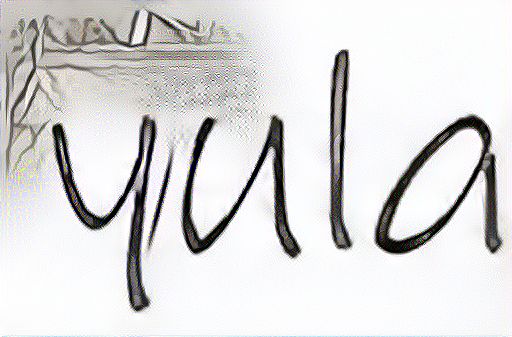

훈련 스텝: 1000
전체 소요 시간: 226.0


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))
  
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [ ]:
# total variation loss를 위한 가중치를 정의해서 train_step 함수에서 이용
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
# 최적화할 변수를 다시 초기화
image = tf.Variable(content_image)

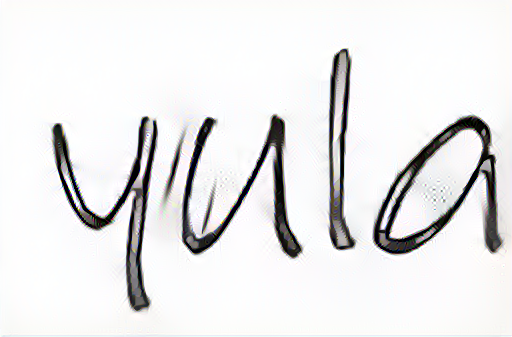

훈련 스텝: 10000
전체 소요 시간: 2260.0


In [ ]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [ ]:
# 결과물 저장
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>